In [265]:
# 1. Підготовка даних
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from pandas.core.interchange.dataframe_protocol import DataFrame
from imblearn.over_sampling import SMOTE
import os
def evaluate_model(x, y, model_):
    y_pred_ = model_.predict(x)
    cm = confusion_matrix(y, y_pred_, labels=model_.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    print(f'F1_score: {f1_score(y, y_pred_)}')
os.chdir("D:\PycharmProjects\MachineLearning")
df = pd.read_csv('adult.csv')
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1}).astype(int)
df.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,race_Asian-Pac-Islander,race_Black,race_Other,race_White,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,38,215646,9,0,0,40,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,53,234721,7,0,0,40,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
4,28,338409,13,0,0,40,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0


In [252]:
# 2. Перевірка балансу класів
df.groupby('income')['age'].count()

income
0    24720
1     7841
Name: age, dtype: int64

Класи не є збалансованами, що може привести до зсуву моделі в бік більшого класу і передбачати лише його. Довіряти 
такій моделі не можна. Для балансування можна штучно збільшити кількість об'єктів меншого класу або зменшити 
кількість об'єктів більшого класу. Accuracy використовувати недоцільно, бо вона чутлива до незбалансованості. Для її 
заміни краще використовувати F-score

In [253]:
# 3. Вибір метрики
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay

In [266]:
# 4. Розділення даних
from sklearn.model_selection import train_test_split, learning_curve
X = df.loc[:, df.columns != 'income']
Y = df['income']
smote = SMOTE()
X, Y = smote.fit_resample(X, Y)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

In [255]:
# 5. Навчання логістичної регресії без регуляризації
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(solver='newton-cholesky')
log_model.fit(x_train, y_train)
print(log_model.get_params())

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'newton-cholesky', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


Train: 


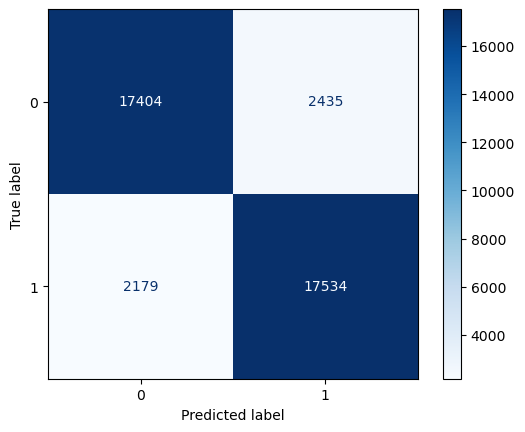

F1_score: 0.8837256186684139
Test: 


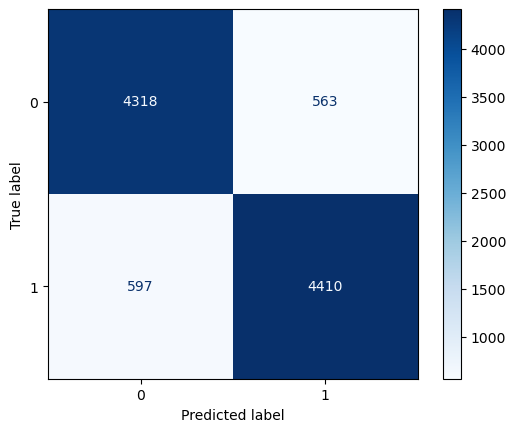

F1_score: 0.8837675350701403


In [256]:
# 6. Оцінка якості моделі
print("Train: ")
evaluate_model(x_train, y_train, log_model)
print("Test: ")
evaluate_model(x_test, y_test, log_model)

In [257]:
# 7. Оцінка якості моделі на основі перехресної перевірки
from sklearn.model_selection import cross_validate, KFold
for cv in [3, 5, 7, 10]:
    scores = cross_validate(log_model, X, Y, scoring='f1', cv=KFold(n_splits=cv, shuffle=True), return_train_score=True)
    print(f"cv = {cv}. Test_F1_score: {scores['test_score'].mean()}. Train_F1_score: {scores['train_score'].mean()}.")

cv = 3. Test_F1_score: 0.8833934968848106. Train_F1_score: 0.8842084837189631.
cv = 5. Test_F1_score: 0.8835535258811632. Train_F1_score: 0.8840031556744103.
cv = 7. Test_F1_score: 0.8835738763340494. Train_F1_score: 0.8840328752238021.
cv = 10. Test_F1_score: 0.8833545202035605. Train_F1_score: 0.8839106766408111.


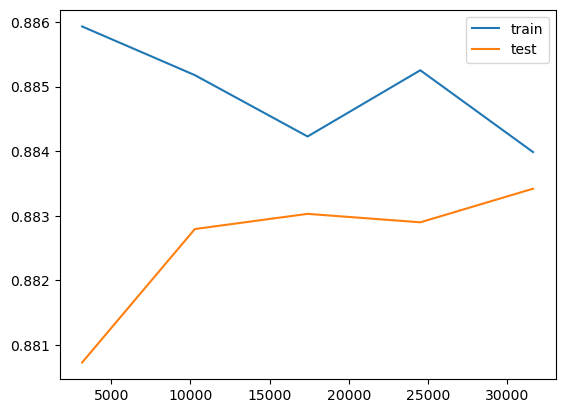

In [258]:
from sklearn.model_selection import learning_curve
sizes, train_score, test_score = learning_curve(log_model, x_train, y_train, train_sizes=np.linspace(0.1, 1.0, 5),cv=KFold(n_splits=5,shuffle=True), scoring='f1')
plt.plot(sizes, train_score.mean(1), label='train')
plt.plot(sizes, test_score.mean(1), label='test')
plt.legend()

(0.5, 1.0)

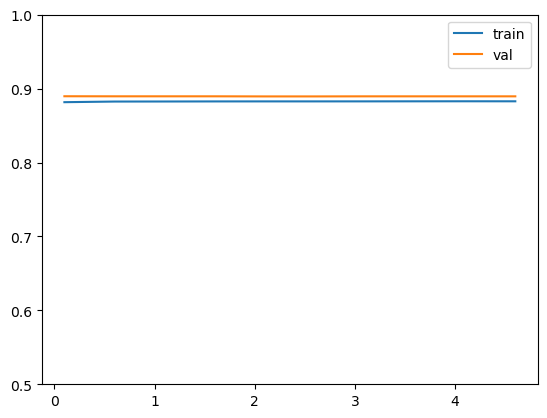

In [259]:
# 8. Навчання логістичної регресії з регуляризацією
x1_train, x_val, y1_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)
C_values = np.arange(0.1, 5.1, 0.5)
train_scores = []
val_scores = []
for c in C_values:  
    log_reg_model = LogisticRegression(solver='newton-cholesky', penalty='l2', C=c)
    log_reg_model.fit(x1_train, y1_train)
    y_pred = log_reg_model.predict(x1_train)
    train_scores.append(f1_score(y1_train, y_pred))
    y_pred = log_reg_model.predict(x_val)
    val_scores.append(f1_score(y_val, y_pred))
plt.plot(C_values, train_scores, label='train')
plt.plot(C_values, val_scores, label='val')
plt.legend()
plt.ylim(0.5, 1)

(0.8, 1.0)

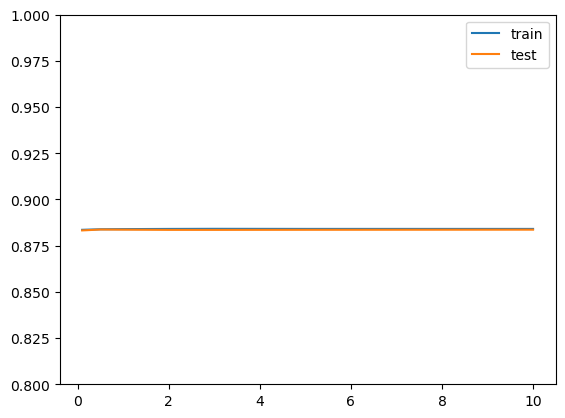

In [260]:
from sklearn.model_selection import validation_curve
log_reg_model = LogisticRegression(solver='newton-cholesky', penalty='l2')
alpha_range = [0.1, 0.5, 1, 2, 3, 5, 10]
train_score, test_score = validation_curve(log_reg_model, x_train, y_train, scoring='f1', param_name='C',
param_range=alpha_range, cv=(KFold(n_splits=5,shuffle=True)))
plt.plot(alpha_range, train_score.mean(1), label='train')
plt.plot(alpha_range, test_score.mean(1), label='test')
plt.legend()
plt.ylim(0.8, 1)

{'C': 10}
0.8833305002647961


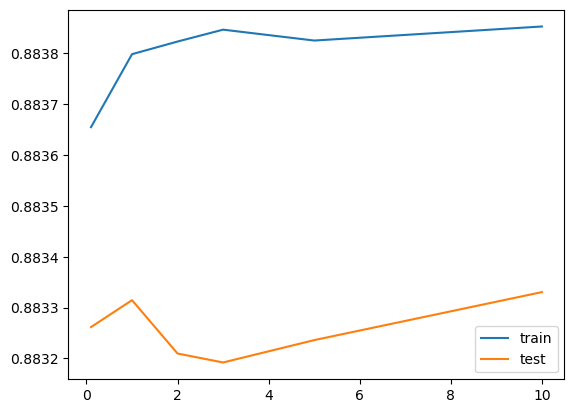

In [261]:
from sklearn.model_selection import GridSearchCV
search = GridSearchCV(log_reg_model, param_grid={'C': [0.1, 1, 2, 3, 5, 10]}, scoring='f1', cv=(KFold(n_splits=5)), return_train_score=True)
search.fit(x_train, y_train)
results = search.cv_results_
train_score = results['mean_train_score']
test_score = results['mean_test_score']
plt.plot([0.1, 1, 2, 3, 5, 10], train_score, label='train')
plt.plot([0.1, 1, 2, 3, 5, 10], test_score, label='test')
plt.legend()
print(search.best_params_)
print(search.best_score_)

Train: 


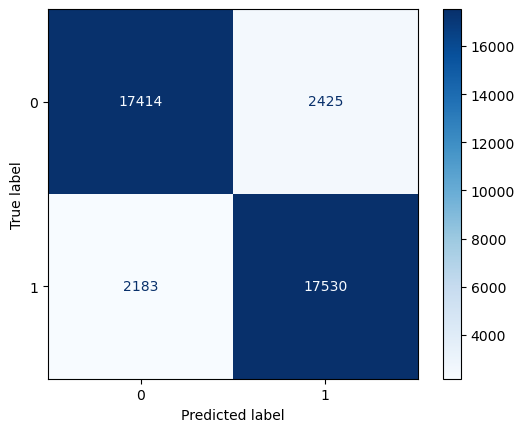

F1_score: 0.883835837450842
Test: 


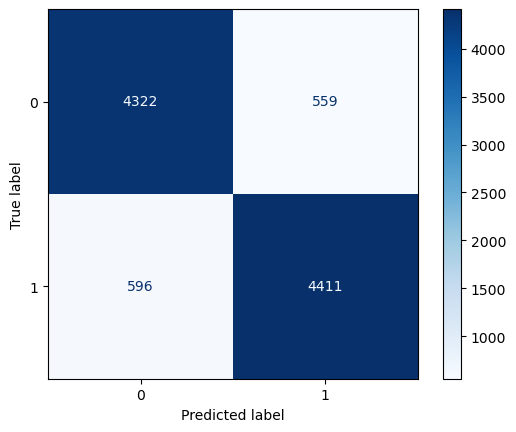

F1_score: 0.8842337375964718


In [262]:
# 9. Оцінка якості моделі з регуляризацією
log_reg_model = search.best_estimator_
log_reg_model.fit(x_train, y_train)
print("Train: ")
evaluate_model(x_train, y_train, log_reg_model)
print("Test: ")
evaluate_model(x_test, y_test, log_reg_model)

education-num                            3.077449
hours-per-week                           0.432720
age                                      0.189732
capital-gain                             0.003147
fnlwgt                                   0.000006
workclass_Never-worked                   0.000000
sex_Male                                -1.333974
marital-status_Separated                -1.405825
native-country_United-States            -1.638477
marital-status_Married-spouse-absent    -3.514496
relationship_Wife                       -6.153049
marital-status_Widowed                  -6.340896
workclass_Private                       -6.743928
workclass_Self-emp-inc                  -7.449403
marital-status_Never-married            -8.073835
occupation_Exec-managerial              -8.236855
occupation_Armed-Forces                 -9.027360
occupation_Prof-specialty              -10.635184
occupation_Tech-support                -11.640345
workclass_Local-gov                    -11.666551


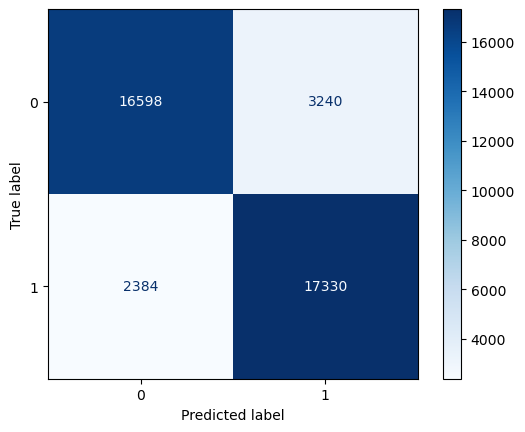

F1_score: 0.8603912223215172
Test: 


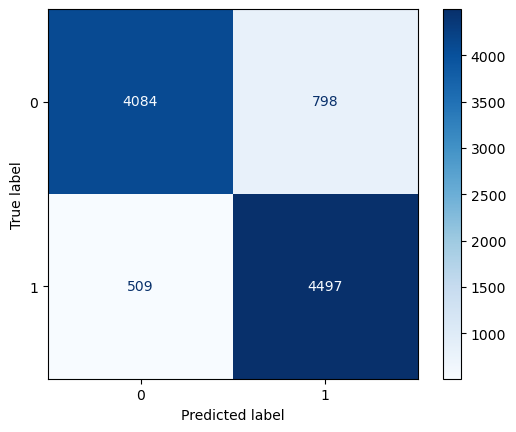

F1_score: 0.8731191146490632


In [268]:
# 10. Відбір ознак
# model = LogisticRegression(solver='liblinear', penalty='l1', max_iter=1000)
# model.fit(x_train, y_train)
# cf = pd.Series(model.coef_[0] * 10, index=x_train.columns)
# print(cf.sort_values(ascending=False))
# df = df.drop(columns=df.filter(like='capital-loss').columns)
# X = df.loc[:, df.columns != 'income']
# Y = df['income']
# smote = SMOTE()
# X, Y = smote.fit_resample(X, Y)
# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)
# log_reg_model.fit(x_train, y_train)
# print("Train: ")
# evaluate_model(x_train, y_train, log_reg_model)
# print("Test: ")
# evaluate_model(x_test, y_test, log_reg_model)

In [ ]:
# 11. Навчання додаткового класифікатора
from sklearn.ensemble import RandomForestClassifier